# FCN-8s-Deeplab Tutorial

In [1]:
from deeplabV2_s_tensorflow import FCN8s
from data_generator.batch_generator import BatchGenerator
from helpers.visualization_utils import print_segmentation_onto_image, create_video_from_images
from cityscapesscripts.helpers.labels import TRAINIDS_TO_COLORS_DICT, TRAINIDS_TO_RGBA_DICT

from math import ceil
import os
import time
import matplotlib.pyplot as plt
%matplotlib inline

/home/com02/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/com02/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/com02/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/com02/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: Futu

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


This notebook walks you through how to work with this FCN-8s implementation. I will take the [Cityscapes dataset](https://www.cityscapes-dataset.com/) as an example to train the model on in this notebook, but the described setup is applicable to arbitrary datasets. Here is an overview of what using this model looks like:

First, you create an instance of the `FCN8s` model class. The constructor is explained in a subsequent next section.

The instantiated `FCN8s` model has the following main public methods:

1. train(): Trains the model.
2. evaluate(): Evaluates the model.
3. predict(): Makes predictions.
4. predict_and_save(): Makes predictions for a sequence of images, prints the predicted segmentations onto them and saves a copy of them to disk.
5. save(): Saves the model to disk.
6. close(): Closes the TensorFlow session. Once you instantiated a model, a session will be started and kept open until you manually close it. It is therefore important that you close the session when you're done working with the model.

[`fcn8s_tensorflow.py`](https://github.com/pierluigiferrari/fcn8s_tensorflow/blob/master/fcn8s_tensorflow.py) provides detailed documentation on the class and all of it's public methods, so take a look.

You can find a link to download a fully convolutionalized VGG-16 that was pre-trained on ImageNet classification in the [README](https://github.com/pierluigiferrari/fcn8s_tensorflow/blob/master/README.md).

In the subsequent sections I'll go step by step over training, evaluation, prediction, and visualization.

## 1. Create a batch generator for training and evaluation

Let's get the preparation out of the way first. The `train()` and `evaluate()` methods need a generator that feeds them with batches of images and corresponding ground truth images. Ideally we want two generators, onr that serves data from a training dataset and another that serves data from a validation dataset. The Cityscapes dataset already provides a split of the data for us, so I'll just stick with that.

In order to train on the Cityscapes dataset, the only thing you really need to do here is set the appropriate paths to the dataset on your machine, for other datasets you will have to pass some different values to the `BatchGenerator` constructor, check the documentation for details.

If you need to preprocess your dataset, e.g. to change the image size or to convert the segmentation class labels, I suggest you do that offline. Take a look at [how to use `BatchGenerator` as an offline preprocessor](https://github.com/pierluigiferrari/fcn8s_tensorflow/blob/master/data_generator/offline_preprocessing_tutorial.ipynb).

In [2]:
# TODO: Set the paths to the images.
# dataset_root_dir = '../data/Cityscapes_small_128_256'
dataset_root_dir = 'data/Cityscapes_small'

train_images = os.path.join(dataset_root_dir, 'leftImg8bit/train/')
val_images = os.path.join(dataset_root_dir, 'leftImg8bit/val/')
test_images = os.path.join(dataset_root_dir, 'leftImg8bit/test/')

# TODO: Set the paths to the ground truth images.
train_gt = os.path.join(dataset_root_dir, 'gtFine/train/')
val_gt = os.path.join(dataset_root_dir, 'gtFine/val/')

# Put the paths to the datasets in lists, because that's what `BatchGenerator` requires as input.
train_image_dirs = [train_images]
train_ground_truth_dirs = [train_gt]
val_image_dirs = [val_images]
val_ground_truth_dirs = [val_gt]

num_classes = 34 # TODO: Set the number of segmentation classes.

train_dataset = BatchGenerator(image_dirs=train_image_dirs,
                               image_file_extension='png',
                               ground_truth_dirs=train_ground_truth_dirs,
                               image_name_split_separator='leftImg8bit',
                               ground_truth_suffix='gtFine_labelIds',
                               check_existence=True,
                               num_classes=num_classes)
num_train_images = train_dataset.get_num_files()
print("Size of training dataset: ", num_train_images, " images")

val_dataset = BatchGenerator(image_dirs=val_image_dirs,
                             image_file_extension='png',
                             ground_truth_dirs=val_ground_truth_dirs,
                             image_name_split_separator='leftImg8bit',
                             ground_truth_suffix='gtFine_labelIds',
                             check_existence=True,
                             num_classes=num_classes)


num_val_images = val_dataset.get_num_files()
print("Size of validation dataset: ", num_val_images, " images")

Size of training dataset:  2975  images
Size of validation dataset:  500  images


In [3]:
# TODO: Set the batch size. I'll use the same batch size for both generators here.
batch_size = 6

train_generator = train_dataset.generate(batch_size=batch_size,
                                         convert_colors_to_ids=False,
                                         convert_ids_to_ids=False,
                                         convert_to_one_hot=True,
                                         void_class_id=None,
                                         random_crop=False,
                                         crop=False,
                                         resize=False,
                                         brightness=False,
                                         flip=0.5,
                                         translate=False,
                                         scale=False,
                                         gray=False,
                                         to_disk=False,
                                         shuffle=True)

val_generator = val_dataset.generate(batch_size=batch_size,
                                     convert_colors_to_ids=False,
                                     convert_ids_to_ids=False,
                                     convert_to_one_hot=True,
                                     void_class_id=None,
                                     random_crop=False,
                                     crop=False,
                                     resize=False,
                                     brightness=False,
                                     flip=False,
                                     translate=False,
                                     scale=False,
                                     gray=False,
                                     to_disk=False,
                                     shuffle=False)

In [4]:
# Print out some diagnostics to make sure that our batches aren't empty and it doesn't take forever to generate them.
start_time = time.time()
images, gt_images = next(train_generator)
print('Time to generate one batch: {:.3f} seconds'.format(time.time() - start_time))
print('Number of images generated:' , len(images))
print('Number of ground truth images generated:' , len(gt_images))

Time to generate one batch: 0.037 seconds
Number of images generated: 4
Number of ground truth images generated: 4


### 1.1 Visualize the dataset

Let's visualize the dataset just to get a better understanding of the ground truth data.

In [5]:
# Generate batches from the train_generator where the ground truth does not get converted to one-hot
# so that we can plot it as images.
example_generator = train_dataset.generate(batch_size=batch_size,
                                           convert_to_one_hot=False)

In [6]:
# Generate a batch.
example_images, example_gt_images = next(example_generator)

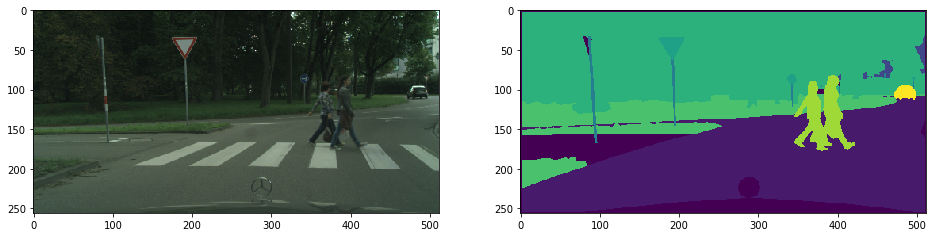

In [7]:
i = 0 # Select which sample from the batch to display below.

figure, cells = plt.subplots(1, 2, figsize=(16,8))
cells[0].imshow(example_images[i])
cells[1].imshow(example_gt_images[i])

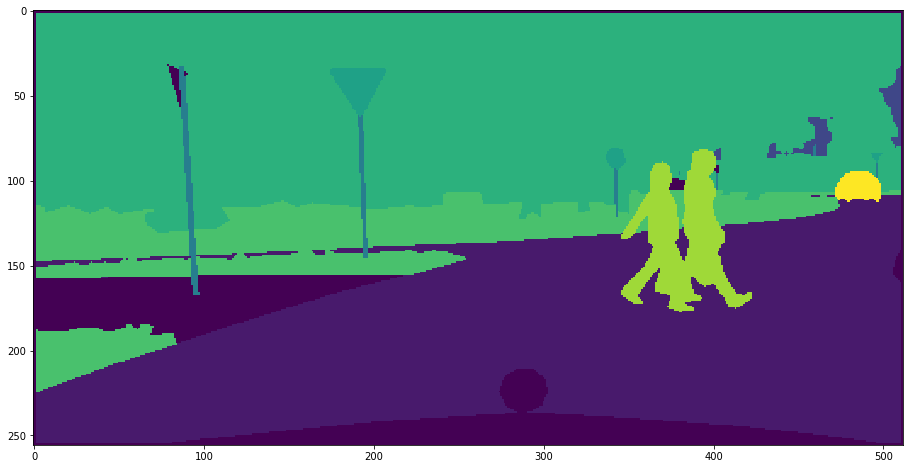

In [8]:
plt.figure(figsize=(16, 8))
plt.imshow(example_gt_images[i])

## 2. Create the model

Instantiate an FCN8s. The constructor arguments might seem a bit confusing, but here is how it works. You can do either of three things:

1. Build the FCN-8s model from scratch, but load a pre-trained VGG-16 model into it. In order to do so, you need to pass values only for `vgg16_dir` (the directory that contains the pre-trained, convolutionalized VGG-16) and for `num_classes`. This is what you will want to do when you are using this model for the first time. You can find the download link to a convolutionalized VGG-16 trained to convergence on ImageNet classification in the README.
2. Load a saved model from a `SavedModel` protocol buffer. In order to do so, you need to pass values only for `model_load_dir` and `tags`. This is what you will likely want to do if you want to use or continue to train a previously saved FCN-8s. If you are unfamiliar with the `SavedModel` API, take a look at [TensorFlow's documentation on this topic](https://www.tensorflow.org/programmers_guide/saved_model#apis_to_build_and_load_a_savedmodel).
3. Build the FCN-8s model from scratch, but load variables into it that were saved using `tf.train.Saver`. In order to do so, you need to pass values only for `variables_load_dir` and `vgg16_dir`. This is what you will want to do if you made any changes to the graph, but still want to load the saved variables from an earlier version of the graph. Unfortunately you still need to provide a VGG-16 `SavedModel`, because I have not manually rebuilt the VGG-16 graph in this implementation, so it needs to be loaded from a saved model.

In [9]:
model = FCN8s(model_load_dir=None,
              tags=None,
              vgg16_dir='data/VGG-16_mod2FCN_ImageNet-Classification',
              num_classes=num_classes,
              variables_load_dir=None)

W0816 09:25:59.212190 139626301495104 deprecation_wrapper.py:119] From /home/com02/samsungAI_project/samsung-ai-expert-semantic-segmentation-project/deeplabV2_s_tensorflow.py:66: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0816 09:25:59.213034 139626301495104 deprecation_wrapper.py:119] From /home/com02/samsungAI_project/samsung-ai-expert-semantic-segmentation-project/deeplabV2_s_tensorflow.py:69: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0816 09:25:59.325972 139626301495104 deprecation.py:323] From /home/com02/samsungAI_project/samsung-ai-expert-semantic-segmentation-project/deeplabV2_s_tensorflow.py:138: load (from tensorflow.python.saved_model.loader_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new func

TensorFlow Version: 1.14.0


W0816 09:26:00.676846 139626301495104 deprecation.py:323] From /home/com02/.local/lib/python3.6/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
W0816 09:26:01.260357 139626301495104 deprecation_wrapper.py:119] From /home/com02/samsungAI_project/samsung-ai-expert-semantic-segmentation-project/deeplabV2_s_tensorflow.py:142: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0816 09:26:01.261085 139626301495104 deprecation_wrapper.py:119] From /home/com02/samsungAI_project/samsung-ai-expert-semantic-segmentation-project/deeplabV2_s_tensorflow.py:168: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0816 09:26:01.262381 139626301495104 deprecation.py:323] From /home/com02/samsungAI_proje

## 3. Train the model

Now just call the `train()` method to train the model. Refer to the documentation for details on all the arguments, but here are a few notes:

1. You'll have to pass some learning rate schedule function, however simple it may be. This function takes as input an integer (the trining step) and returns a float (the learning rate). I'll just define a simple step function below.
2. Pass the generator(s) we instantiated above. Note that there are two arguments that take a generator as input, `train_generator` and `val_generator`, where the latter is optional.

In [10]:
epochs = 30 # TODO: Set the number of epochs to train for.

# TODO: Define a learning rate schedule function to be passed to the `train()` method.
def learning_rate_schedule(step):
    if step <= 12000: return 0.0001
    elif 12000 < step <= 24000: return 0.00001
    elif 24000 < step <= 36000: return 0.000003
    else: return 0.000001
    
model.train(train_generator=train_generator,
            epochs=epochs,
            steps_per_epoch=ceil(num_train_images/batch_size),
            learning_rate_schedule=learning_rate_schedule,
            keep_prob=0.5,
            l2_regularization=0.0,
            eval_dataset='val',
            eval_frequency=5,
            val_generator=val_generator,
            val_steps=ceil(num_val_images/batch_size),
            metrics={'loss', 'mean_iou', 'accuracy'},
            save_during_training=False,
            save_dir='cityscapes_model',
            save_best_only=True,
            save_tags=['default'],
            save_name='(batch-size-4)',
            save_frequency=2,
            saver='saved_model',
            monitor='loss',
            record_summaries=False,
            summaries_frequency=10,
            summaries_dir='tensorboard_log/cityscapes',
            summaries_name='deeplab_01',
            training_loss_display_averaging=3)

Default GPU Device: /device:GPU:0
Evaluation on validation dataset: 100%|██████████| 125/125 [00:42<00:00,  2.12it/s]
loss: 0.7043  mean_iou: 0.3422  accuracy: 0.8417  
per_class_iou: 
0.3408146, 0.8168638, 0.5065303, 0.8430386, 0.0, 0.0025380705, 0.017125247, 0.0, 0.3820114, 0.73147017, 0.0, 0.8428743, 0.0, 0.0, 0.7400732, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
Evaluation on validation dataset: 100%|██████████| 125/125 [01:17<00:00,  1.34it/s]
loss: 0.5478  mean_iou: 0.4482  accuracy: 0.8645  
per_class_iou: 
0.34825647, 0.80086225, 0.6286358, 0.86746216, 0.0, 0.0, 0.16189124, 0.0, 0.34775767, 0.79568493, 0.46409336, 0.86584353, 0.0, 0.0, 0.747503, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
Evaluation on validation dataset: 100%|██████████| 125/125 [01:51<00:00,  1.02s/it]
loss: 0.5159  mean_iou: 0.4860  accuracy: 0.8739  
per_class_iou: 
0.36414817, 0.7835141, 0.7309618, 0.869041

## 3. Save the model

I already set the `train()` method above to save the model to disk during the training, so the model has already been saved (potentially multiple times) and it's not necessary to save it manually, but here is the exemplary method call just for the sake of completeness.

In [ ]:
model.save(model_save_dir='cityscapes_model',
           saver='saved_model',
           tags=['default'],
           name='(batch-size-4)',
           include_global_step=True,
           include_last_training_loss=True,
           include_metrics=True,
           force_save=False)

## 4. Evaluate the model

I already set the `train()` method above to evaluate the model every few epochs during training, but you can evaluate the model explicitly as shown below. There are currently three metrics built in: (1) Mean intersection over union, which is probably the most important metric for semantic segmentation models, (2) accuracy, which simply measures the ratio of images pixels that were classified correctly, and (3) loss, which is simply the output of the loss function. You can evaluate the model on any subset of them.

In [11]:
model.evaluate(data_generator=val_generator,
               metrics={'loss', 'mean_iou', 'accuracy'},
               num_batches=ceil(num_val_images/batch_size),
               l2_regularization=0.0,
               dataset='val')

Running evaluation: 100%|██████████| 125/125 [04:16<00:00,  2.20s/it]
loss: 0.5333  mean_iou: 0.5233  accuracy: 0.8819  
per_class_iou: 
0.40556765, 0.80301857, 0.68611586, 0.8967162, 0.0, 0.025363358, 0.15707089, 0.0, 0.5921411, 0.80962384, 0.38271615, 0.9001602, 0.0, 0.0, 0.7485149, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0


## 5. Make predictions and visualize them

In [41]:
images, labels = next(val_generator)

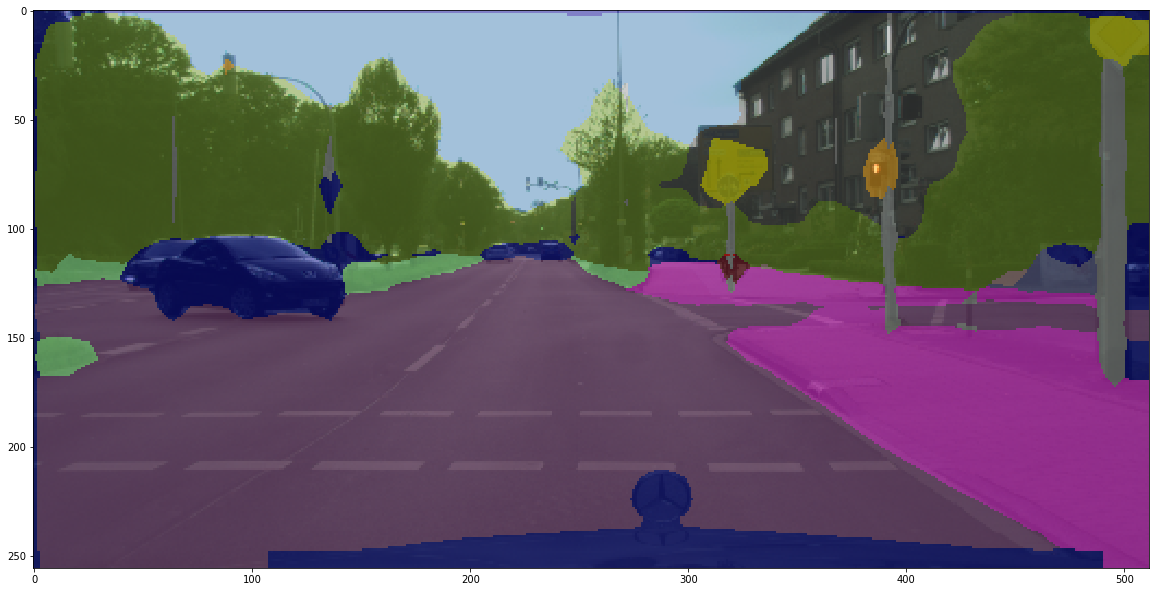

In [42]:
n = 0 # Select which image of the batch you would like to visualize.

# Make a prediction.
prediction = model.predict([images[n]], argmax=False)

# Print the predicted segmentation onto the image.
segmented_image = print_segmentation_onto_image(images[n], prediction, color_map=TRAINIDS_TO_RGBA_DICT)

plt.figure(figsize=(20,14))
plt.imshow(segmented_image)

## 6. Close the session

Remember, the TensorFlow session is being kept open and keeps owning resources until you manually close it, so don't forget to close it when you're done in order to release the resources.

In [ ]:
model.close()